In [13]:
import pandas as pd
import matplotlib.pyplot as plt
#import pandas_datareader as web
from pandas_datareader import data as web
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

crypto='BTC'
real='BRL'
against='USD'

start=dt.datetime(2016,1,1)
end=dt.datetime.now()

In [4]:
print(start)
print(end)

2016-01-01 00:00:00
2023-04-22 14:14:03.497672


In [17]:
teste=f'{crypto}-{against}'
print(teste)
import yfinance as yfin
yfin.pdr_override()
#bit_usd = web.DataReader(teste,'yahoo',start,end)
data = yfin.download(teste, start , end)
data.head()
#brl_usd = web.DataReader(f'{real}-{against}','yahoo',start,end)

BTC-USD
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [20]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
train_days=60
x_train,y_train = [],[]
for x in range(train_days,len(scaled_data)):
    x_train.append(scaled_data[x-train_days:x,0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train),np.array(y_train)
x_train= np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [27]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
82/82 [==============================] - 45s 233ms/step - loss: 0.0063
Epoch 2/25
82/82 [==============================] - 14s 171ms/step - loss: 0.0031
Epoch 3/25
82/82 [==============================] - 8s 92ms/step - loss: 0.0026
Epoch 4/25
82/82 [==============================] - 7s 87ms/step - loss: 0.0025
Epoch 5/25
82/82 [==============================] - 8s 101ms/step - loss: 0.0022
Epoch 6/25
82/82 [==============================] - 9s 106ms/step - loss: 0.0020
Epoch 7/25
82/82 [==============================] - 8s 97ms/step - loss: 0.0021
Epoch 8/25
82/82 [==============================] - 9s 115ms/step - loss: 0.0017
Epoch 9/25
82/82 [==============================] - 11s 138ms/step - loss: 0.0016
Epoch 10/25
82/82 [==============================] - 14s 175ms/step - loss: 0.0016
Epoch 11/25
82/82 [==============================] - 19s 231ms/step - loss: 0.0016
Epoch 12/25
82/82 [==============================] - 18s 222ms/step - loss: 0.0015
Epoch 13/25
82/82 [===

In [28]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yfin.download(teste, test_start , test_end)
test_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [29]:
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'],test_data['Close']),axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-train_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(train_days,len(model_inputs)):
    x_test.append(model_inputs[x-train_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

38/38 [==============================] - 7s 66ms/step


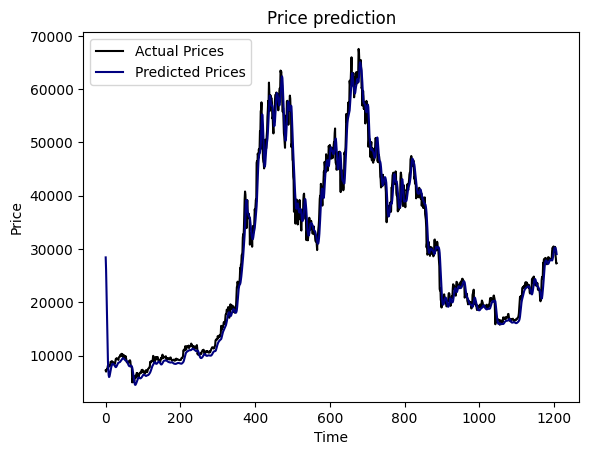

In [33]:
plt.plot(actual_prices,color="black",label="Actual Prices")
plt.plot(prediction_prices,color="#000080",label='Predicted Prices')
plt.title("Price prediction")
plt.xlabel('Time')
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.show()

In [36]:
real_data = [model_inputs[len(model_inputs)+1 - train_days:len(model_inputs)+1,0]]
real_data =np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 2s 2s/step
[[28432.227]]
